# Load your IBM Quantum account and get the quantum backend

We'll be using the 27-qubit device `ibmq_montreal` for this tutorial.

In [1]:
import os
path = 'qiskit-runtime'
  # Check whether the specified
# path exists or not
Exist = os.path.exists(path)

#Si no existe el path clonaremos el repositorio en ese path, si ya existe no haremos nada.
if Exist == False: 
    print('Clonando Repositorio...')
    !git clone https://github.com/Qiskit-Partners/qiskit-runtime.git
    
else: 
    print('No se clonará el repositorio debido a que ya existe en el sistema')

No se clonará el repositorio debido a que ya existe en el sistema


In [2]:
import sys
sys.path.insert(0, 'qiskit-runtime') # Path al repositorio de RUNTIME desde IBM Quantum Lab

# Invoke the Quantum Kernel Alignment program

Before executing the runtime program for QKA, we need to prepare the dataset and configure the input parameters for the algorithm.

### 1. Prepare the dataset

First, we load the dataset from the `csv` file and then extract the labeled training and test samples. Here, we'll look at the 7-qubit problem, shown above in subfigure a). A second dataset is also available for the 10-qubit problem in b).

In [3]:
# Libraries needed for the tutorial

import pandas as pd
import requests
import io
    
# Downloading the csv file from your GitHub account

url = "https://raw.githubusercontent.com/Qiskit-Partners/qiskit-runtime/main/qiskit_runtime/qka/aux_file/dataset_graph7.csv" # Make sure the url is the raw version of the file on GitHub

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(url,header= None)

#columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,14]

#df = df[columns]

data = df.values

Let's take a look at the data to see how it's formatted. Each row of the dataset contains a list of Euler angles, followed by the class label $\pm1$ in the last column. For an $n$-qubit problem, there are $2n$ features corresponding to the first two Euler angles for each qubit (recall discussion above). The rows alternate between class labels.

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.193574,0.113979,-0.005927,0.300957,-0.358603,-0.087866,-0.156226,0.342442,-0.016003,0.143113,0.256422,-0.164125,-0.136743,0.014674,1.0
1,-0.100006,0.002431,0.244218,0.126870,-0.063891,-0.085588,0.072490,0.042986,-0.052714,0.019754,-0.159314,-0.409991,-0.199615,0.053845,-1.0
2,-1.774448,-0.047642,-0.025880,0.252708,-0.350689,-1.604509,-0.114874,0.347631,0.059501,-0.168956,0.351014,-0.128586,0.098897,-0.047799,1.0
3,-0.211585,-0.043782,-1.560226,0.018510,-0.051867,-0.128508,0.218609,-0.075632,-0.183656,-1.715292,-0.105361,-0.300758,-0.566431,0.046542,-1.0
4,-0.105965,0.208387,-0.003896,0.163816,-0.332541,-1.594675,-1.889321,-0.251937,0.374445,-1.431062,0.290588,0.118851,0.048799,-0.073023,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-1.860920,-0.030419,-1.688612,0.007305,0.066572,-1.711844,-1.393033,-0.083453,0.055720,-1.518301,-1.576734,0.208194,-1.813403,-0.106302,-1.0
124,-0.316567,-1.599647,0.113329,-1.413006,-1.761544,-0.044818,-1.810205,-0.289997,-1.566337,-0.277979,-1.298275,-1.490769,-1.663696,-1.562536,1.0
125,-1.489406,-1.564369,-0.012539,0.023483,-1.559397,-1.477378,-1.423428,-1.385349,-0.111253,0.088187,-1.501800,-1.270020,-1.645927,-0.106986,-1.0
126,-1.744036,-1.852529,-0.048826,-1.300941,-1.853251,-1.660622,-1.767232,-0.162640,-1.314748,-0.055515,-1.308294,-1.485198,-1.535383,-1.519175,1.0


Now, let's explicitly construct the training and test samples (denoted `x`) and their labels (denoted `y`).

In [5]:
import numpy as np

# choose number of training and test samples per class:
num_train = 10
num_test = 10

# extract training and test sets and sort them by class label
train = data[:2*num_train, :]
test = data[2*num_train:2*(num_train+num_test), :]

ind=np.argsort(train[:,-1])
x_train = train[ind][:,:-1]
y_train = train[ind][:,-1]

ind=np.argsort(test[:,-1])
x_test = test[ind][:,:-1]
y_test = test[ind][:,-1]


### 2. Configure the QKA algorithm

The first task is to set up the feature map and its entangler map, which specifies the arrangement of $CZ$ gates in the fiducial state. We will choose this to match the connectivity of the problem subgraph, pictured above. We also initialize the fiducial state parameter $\lambda$ with `initial_point`.

In [6]:
import numpy as np
import numpy.matlib as matl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from IPython.display import display

import pandas as pd
import sklearn.preprocessing as skpp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import cluster, datasets, mixture



np.random.seed(19)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
import time

grid = [{'C': [0.1,1.0,10],
         'gamma': ['auto',1.0,0.1], 
         'kernel': ['rbf','poly'],
         'degree': [1,2,3,4,5],
         'coef0':[1.0]}]

clf_gridsearch = GridSearchCV(estimator=SVC(probability=True), param_grid=grid, cv=5)
start = time.time()
clf_gridsearch.fit(x_train, y_train) 
stop = time.time()
print(f"Training time: {stop - start}s") 

# Imprimimos los resultados para el mejor clasificador:
clf = clf_gridsearch.best_estimator_
print("Best model:")
print(clf.get_params())

# Calculamos el acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(x_train, y_train)
print("Score in training set = %f" % (score_train))

score_test = clf.score(x_test, y_test)
print("Score in test set = %f" % (score_test))

Training time: 0.5702366828918457s
Best model:
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 1.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1.0, 'kernel': 'poly', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Score in training set = 1.000000
Score in test set = 0.700000


In [8]:
from qiskit_runtime.qka import FeatureMap

d = np.shape(data)[1]-1                                         # feature dimension is twice the qubit number

em = [
    [0, 2],
    [3, 4],
    [2, 5],
    [1, 4],
    [2, 3],
    [4, 6],
] # we'll match this to the 7-qubit graph              
# em = [[0,1],[2,3],[4,5],[6,7],[8,9],[1,2],[3,4],[5,6],[7,8]]  # we'll match this to the 10-qubit graph

fm = FeatureMap(feature_dimension=d, entangler_map=em)          # define the feature map
initial_point = [0.1]                                           # set the initial parameter for the feature map

Let's print out the circuit for the feature map (the circuit for the kernel will be a feature map for one data sample composed with an inverse feature map for a second sample). The first part of the feature map is the fiducial state, which is prepared with a layer of $y$ rotations followed by $CZ$s. Then, the last two layers of $z$ and $x$ rotations in the circuit denote the group representation $D(\theta)$ for a data sample $\theta$. Note that a single-qubit rotation is defined as $RP(\phi) = \exp(- i [\phi/2] P)$ for $P \in {X, Y, Z}$.

In [9]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(fm.construct_circuit(x=x_train[0], parameters=initial_point), 
               output='text', fold=200)

┌──────────┐   ┌──────────────┐ ┌────────────┐                                                 
q_0: ┤ Ry(-0.1) ├─■─┤ Rz(-0.38383) ├─┤ Rx(3.3378) ├─────────────────────────────────────────────────
     ├──────────┤ │ └──────────────┘ └────────────┘┌──────────────┐ ┌──────────────┐                
q_1: ┤ Ry(-0.1) ├─┼────────────────────────■───────┤ Rz(-0.11811) ├─┤ Rx(-0.20449) ├────────────────
     ├──────────┤ │                        │       └──────────────┘ └┬────────────┬┘┌─────────────┐ 
q_2: ┤ Ry(-0.1) ├─■────────■───────────────┼──────────────■──────────┤ Rz(3.4802) ├─┤ Rx(0.15495) ├─
     ├──────────┤          │               │              │         ┌┴────────────┤ ├─────────────┴┐
q_3: ┤ Ry(-0.1) ├─■────────┼───────────────┼──────────────■─────────┤ Rz(0.34764) ├─┤ Rx(-0.54085) ├
     ├──────────┤ │        │               │                        ├─────────────┤ ├──────────────┤
q_4: ┤ Ry(-0.1) ├─■────────┼───────────────■──────────────■─────────┤ Rz(0.34312) ├─┤ Rx(-0.14015) ├
     ├──────────┤          │        ┌─────────────┐       │        ┌┴─────────────┴┐└──────────────┘
q_5: ┤ Ry(-0.1) ├──────────■────────┤ Rz(0.51497) ├───────┼────────┤ Rx(-0.029293) ├────────────────
     ├──────────┤                   └─────────────┘       │        └┬──────────────┤┌─────────────┐ 
q_6: ┤ Ry(-0.1) ├─────────────────────────────────────────■─────────┤ Rz(-0.42725) ├┤ Rx(0.44115) ├─
     └──────────┘                                                   └──────────────┘└─────────────┘

Next, we set the values for the SVM soft-margin penalty `C` and the number of SPSA iterations `maxiters` we use to align the quantum kernel.

In [10]:
C = 1                                                           # SVM soft-margin penalty
maxiters = 10                                                   # number of SPSA iterations

Finally, we decide how to map the virtual qubits of our problem graph to the physical qubits of the hardware. For example, in the 7-qubit problem, we can directly map the virtual qubits `[0, 1, 2, 3, 4, 5, 6]` to the physical qubits `[10, 11, 12, 13, 14, 15, 16]` of the device. This allows us to avoid introducing SWAP gates for qubits that are not connected, which can increase the circuit depth. 

In [11]:
initial_layout = [10, 11, 12, 13, 14, 15, 16]                   # see figure above for the 7-qubit graph
# initial_layout = [9, 8, 11, 14, 16, 19, 22, 25, 24, 23]       # see figure above for the 10-qubit graph

### 3. Set up and run the program

We're almost ready to run the program. First, let's take a look at the program metadata, which includes a description of the input parameters and their default values.

We see that this program has several input parameters, which we'll configure below. To run the program, we'll set up its two main components: `inputs` (the input parameters from the program metadata) and `options` (the quantum backend). We'll also define a callback function so that the intermediate results of the algorithm will be printed as the program runs. Note that each step of the algorithm for the settings we've selected here takes approximately 11 minutes.

In [12]:
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}\n")

In [13]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(
	hub='ibm-q',
	group='open',
	project='main'
)

program_inputs = {
    'feature_map': fm,
    'data': x_train,
    'labels': y_train,
    'initial_kernel_parameters': initial_point,
    'maxiters': maxiters,
    'C': C,
    'initial_layout': initial_layout
}

options = {'backend_name': 'ibmq_qasm_simulator'}

job = provider.runtime.run(program_id="quantum-kernel-alignment",
                              options=options,
                              inputs=program_inputs,
                              callback=interim_result_callback,
                              )

print(job.job_id())
result = job.result()

c94s8s03vrh92e71rtkg
interim result: {'cost': 11.833607201924274, 'kernel_parameters': array([0.24230665])}

interim result: {'cost': 11.161217951189371, 'kernel_parameters': array([0.45640994])}

interim result: {'cost': 9.337862188255892, 'kernel_parameters': array([0.70755898])}

interim result: {'cost': 7.007005496740668, 'kernel_parameters': array([0.88722927])}

interim result: {'cost': 5.6984919014837825, 'kernel_parameters': array([1.00480097])}

interim result: {'cost': 5.112264733131618, 'kernel_parameters': array([1.08058047])}

interim result: {'cost': 4.76371989842748, 'kernel_parameters': array([1.13901238])}

interim result: {'cost': 4.575294972360512, 'kernel_parameters': array([1.18324921])}

interim result: {'cost': 4.461741637631928, 'kernel_parameters': array([1.21589843])}

interim result: {'cost': 4.397969667649619, 'kernel_parameters': array([1.24106524])}

interim result: {'aligned_kernel_parameters': array([1.24106524]), 'aligned_kernel_matrix': array([[1.     

### 4. Retrieve the results of the program

Now that we've run the program, we can retrieve the output, which is the aligned kernel parameter and the aligned kernel matrix. Let's also plot this kernel matrix (we'll subtract off the diagonal to show the contrast between the remaining entries). The kernel matrix is expected to have a block-diagonal structure. This reflects the fact that the kernel maps the input data effectively to just two states (modulo the small noise we added to the data; recall the discussion above). That is, data in the same coset (same class label) have a larger overlap than do data from different cosets.

aligned_kernel_parameters: [1.24106524]


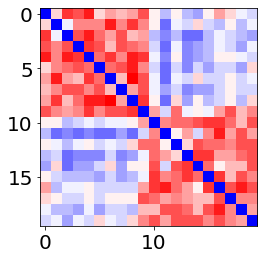

In [14]:

result = job.result()

print(f"aligned_kernel_parameters: {result['aligned_kernel_parameters']}")

from matplotlib import pyplot as plt
from pylab import cm
plt.rcParams['font.size'] = 20
plt.imshow(result['aligned_kernel_matrix']-np.identity(2*num_train), cmap=cm.get_cmap('bwr', 20))
plt.show()

# Use the results of the program to test an SVM on new data

Equipped with the aligned kernel and its optimized parameter, we can use the `sklearn` package to train an SVM and then evaluate its classification accuracy on new test points. Note that a second kernel matrix built from the test points is needed for the SVM decision function.

In [19]:
from qiskit_runtime.qka import KernelMatrix
from qiskit.providers.aer import QasmSimulator
from sklearn.svm import SVC
from sklearn import metrics

# train the SVM with the aligned kernel matrix:

kernel_aligned = result['aligned_kernel_matrix']
model = SVC(C=C, kernel='precomputed')
model.fit(X=kernel_aligned, y=y_train)

# test the SVM on new data:
backend = QasmSimulator()
km = KernelMatrix(feature_map=fm, backend=backend, initial_layout=initial_layout)
kernel_test = km.construct_kernel_matrix(x1_vec=x_test, x2_vec=x_train, parameters=result['aligned_kernel_parameters'])
labels_test = model.predict(X=kernel_test)
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")


accuracy test: 1.0


In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright